In [1]:
from pyscipopt import Model, Heur, Eventhdlr, Conshdlr, quicksum, SCIP_RESULT, SCIP_EVENTTYPE, SCIP_HEURTIMING

In [2]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def read_instance(name):
    x ={}
    y ={}
    xy = {}
    with open(name) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            sp = line.split()
            if len(sp) > 0 and sp[0].isnumeric():
                assert len(sp) == 3
                assert is_number(sp[1]) and is_number(sp[2])
                x[cnt] = float(sp[1])
                y[cnt] = float(sp[2])

                # dictionary from node to its coordinates: we use this for plotting the graph
                xy[cnt] = (x[cnt], y[cnt])
                cnt += 1
            line = fp.readline()
    return x, y, xy

In [3]:
import math

def distance(x1,y1,x2,y2):
    """distance: euclidean distance between (x1,y1) and (x2,y2)"""
    return round(math.sqrt((x2-x1)**2 + (y2-y1)**2),2)

def compute_distance_matrix(x,y):
    n = len(x)
    V = range(1,n)
    c={}
    for i in V:
        for j in V:
            if j > i:
                c[i,j] = distance(x[i],y[i],x[j],y[j])
    return c

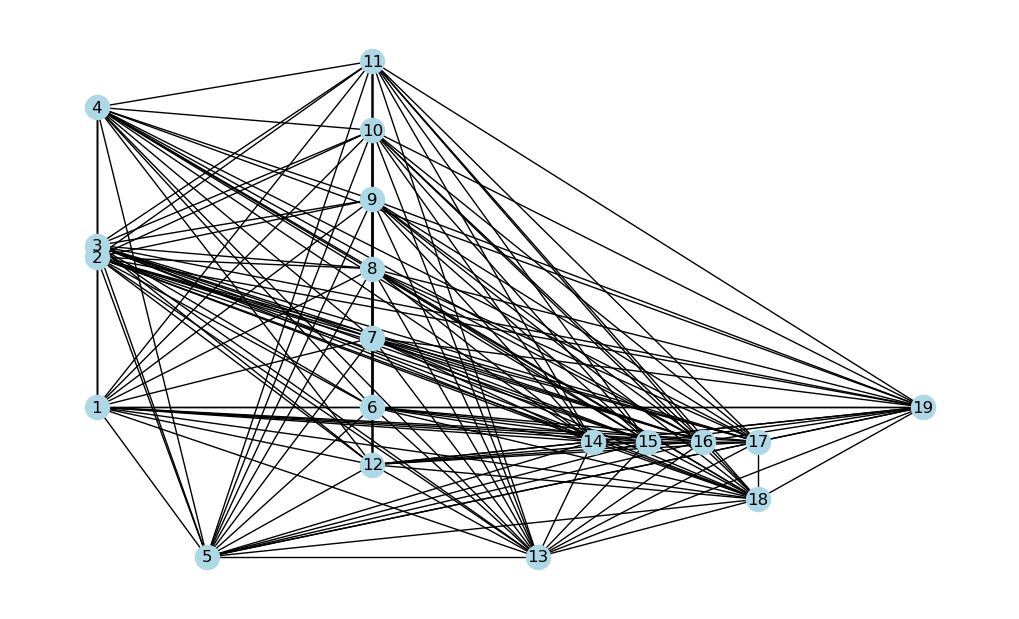

In [8]:
import networkx
import matplotlib.pyplot as plt

# read instance
x, y, xy = read_instance('D:/github/ALNS/test/tsp-data/p01.tsp')
V = range(1, len(x))

# make plot look nicer
plt.figure(figsize=(10,6), dpi=100) 

# define empty graph
graph = networkx.Graph()

# the graph is complete so there are edges between every pair of nodes
edgelist = [(i,j) for i in V for j in V if j > i]

# add edges
graph.add_edges_from(edgelist)

# draw the graph, place the nodes using x,y coordinates
networkx.draw(graph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

# show plot
plt.show()

In [10]:
def createVars(model, V):
    x = {}
    for i in V:
        for j in V:
            if j > i:
                # here add your code:
                x[i,j] = model.addVar(name="x(%s,%s)"%(i,j), vtype = 'B')
    return x

In [11]:
def setObjective(model, x, c):
    # add your code: (or probably this could be given, or we improve the intro section so that we show an example like this, that uses quicksum and dictionaries)
    model.setObjective(quicksum(c[i,j]*x[i,j] for (i,j) in x), "minimize")

In [12]:

def addComeAndGoConstraints(model, V, x):
    for j in V:
        # add your code
        model.addCons( quicksum(x[i,j] for i in V if i < j) + \
                   quicksum(x[j,i] for i in V if i > j) == 2, "ComeAndGo(%s)"%j)

In [40]:
# (dummy) Event handler
# class NewSolEvent(Eventhdlr):

#     # we pass some information we need the event handler to know, like the variables
#     # and the positions of the nodes
#     def __init__(self, vars_dict, coords_nodes):
#         self.data = {}
#         self.data['vars'] = vars_dict
#         self.data['xy'] = coords_nodes

#     # initialization method: here we tell SCIP that we want to listen to the BESTSOLFOUND event,
#     # that is, we want to be called whenever a new best solution is found
#     def eventinit(self):
#         self.model.catchEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

#     # here we stop listening to the event we were listening to
#     def eventexit(self):
#         self.model.dropEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

#     # execution method of the event handler
#     def eventexec(self, event):
#         print("EVENT: new best sol found. TODO: visualize the solution")
#         pass
    
# Event handler
class NewSolEvent(Eventhdlr):

    def __init__(self, vars_dict, coords_nodes):
        self.data = {}
        self.data['vars'] = vars_dict
        self.data['xy'] = coords_nodes

    # we want to be called whenever a new best sol is found
    def eventinit(self):
        self.model.catchEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    # stop listening to event
    def eventexit(self):
        self.model.dropEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    def eventexec(self, event):
        assert event.getType() == SCIP_EVENTTYPE.BESTSOLFOUND
        # get best sol
        sol = self.model.getBestSol()

        # get vars and position of vertices
        x = self.data['vars']
        xy = self.data['xy']

        # plot solution
        # Collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
        edges = []
        for (i,j) in x:
            if model.getSolVal(sol, x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
                edges.append( (i,j) )

        # make figure look nicer
        plt.figure(figsize=(10,6), dpi=100)
        
        # create empty graph
        optgraph = networkx.Graph()
        
        # add edges
        optgraph.add_edges_from(edges)
        
        # draw the nodes, with labels in the position xy (see when we read the instance)
        networkx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')
        
        # show drawing
        plt.show()
        
        components = list(networkx.connected_components(optgraph))

        print(components)
        
        
# (dummy) Heuristic 
class TwoOpt(Heur):

    # we pass some information we need the heuristic to know, like the variables
    # and the costs of the edges
    def __init__(self, costs, vars_dict):
        self.data = {}
        self.data['costs'] = costs
        self.data['vars'] = vars_dict
        self.data['primalbound'] = -1.0

    # execution method of the heuristic. 
    
    def heurexec(self, heurtiming, nodeinfeasible):
        
        # 2 Opt is an improving heuristic and so it should run only
        # once per new solution. To realize if we should run, that is, if there is a solution and this solution is 
        # different from the time we were called, we store the primal bound of the last solution we saw.
        # NOTE: it would be easier to just ask whether the solutions are the same, however, this does not work
        # with the current state of PySCIPOpt.
        
        # get primal bound
        primalbound = self.model.getPrimalbound()
        
        # if we have no solution yet don't run
        if self.model.isInfinity(primalbound):
            return {"result": SCIP_RESULT.DIDNOTRUN}
        
        # if we already saw this solution do not run
        if primalbound == self.data['primalbound']:
            return {"result": SCIP_RESULT.DIDNOTRUN}
        
        # remember the new primal bound we are seeing
        self.data['primalbound'] = primalbound
        
        print("HEURISTIC: we should try to improve the solution with 2-opt")
        return {"result": SCIP_RESULT.DIDNOTFIND}

In [30]:
# (dummy) subtour elimination constraint handler
# class SEC(Conshdlr):

#     # method for creating a constraint of this constraint handler type
#     def createCons(self, name, variables):
#         model = self.model
#         cons = model.createCons(self, name)
        
#         # data relevant for the constraint; in this case we only need to know which
#         # variables cannot form a subtour
#         cons.data = {}
#         cons.data['vars'] = variables
#         return cons


#     # checks whether solution is feasible; we just say yes
#     def conscheck(self, constraints, solution, check_integrality,
#                   check_lp_rows, print_reason, completely, **results):
#         for cons in constraints:
#             print("CONSHDLR: should check if ", cons, " is feasible")
#         return {"result": SCIP_RESULT.FEASIBLE}

#     # enforces the LP solution; we just say we are feasible
#     def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
#         for cons in constraints:
#             print("CONSHDLR: should enforce ", cons)
#         return {"result": SCIP_RESULT.FEASIBLE}


#     # this is rather technical and not relevant for the exercise. to learn more see 
#     # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
#     def conslock(self, constraint, locktype, nlockspos, nlocksneg):
#         pass

# subtour elimination constraint handler
class SEC(Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)
        
        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons

    
    # find subtours in the graph induced by the edges {i,j} for which x[i,j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        edges = []
        x = cons.data['vars']
        
        for (i, j) in x:
            if self.model.getSolVal(solution, x[i, j]) > 0.5:
                edges.append((i, j))

        G = networkx.Graph()
        G.add_edges_from(edges)
        components = list(networkx.connected_components(G))

        if len(components) == 1:
            return []
        else:
            return components

    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):
        
        # check if there is a violated subtour elimination constraint
        for cons in constraints:
            if self.find_subtours(cons, solution):
                return {"result": SCIP_RESULT.INFEASIBLE}
        
        # no violated constriant found -> feasible
        return {"result": SCIP_RESULT.FEASIBLE}

    
    # enforces the LP solution: searches for subtours in the solution and adds 
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        consadded = False
        
        for cons in constraints:
            subtours = self.find_subtours(cons)
        
            # if there are subtours
            if subtours:
                x = cons.data['vars']

                # add subtour elimination constraint for each subtour
                for S in subtours:
                    self.model.addCons(quicksum(x[i, j] for i in S for j in S if j>i) <= len(S)-1)
                    consadded = True

        if consadded:
            return {"result": SCIP_RESULT.CONSADDED}
        else:
            return {"result": SCIP_RESULT.FEASIBLE}


    # this is rather technical and not relevant for the exercise. to learn more see 
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

In [25]:
def addSubtourElimination(model, x):
    # create the constraint handler
    conshdlr = SEC()

    # Add the constraint handler to SCIP. We set check priority < 0 so that only integer feasible solutions
    # are passed to the conscheck callback
    model.includeConshdlr(conshdlr, "TSP", "TSP subtour eliminator", chckpriority = -10, enfopriority = -10)

    # create a subtour elimination constraint
    cons = conshdlr.createCons("no_subtour_cons", x)

    # add constraint to SCIP
    model.addPyCons(cons)

In [49]:
def setupModel(instance):
    xcoords, ycoords, xy = read_instance(instance)
    c = compute_distance_matrix(xcoords, ycoords)
    
    model = Model()
    V = range(1, len(xcoords))
    
    x = createVars(model, V)
    setObjective(model, x, c)
    addComeAndGoConstraints(model, V, x)
    addSubtourElimination(model, x)
    
    # create and add event handler
#     model.includeEventhdlr(NewSolEvent(x, xy), "NewSolEvent", "Prints new sol found")
    # create and add heuristic
#     model.includeHeur(TwoOpt(c, x), "2opt", "2 Opt Heuristic", "K", timingmask=SCIP_HEURTIMING.AFTERLPNODE)

    
    return model, x


In [45]:
instance = 'D:/github/ALNS/test/tsp-data/p01.tsp'
xcoords, ycoords, xy = read_instance(instance)
c = compute_distance_matrix(xcoords, ycoords)

In [51]:
xy

{1: (0.0, 13.0),
 2: (0.0, 26.0),
 3: (0.0, 27.0),
 4: (0.0, 39.0),
 5: (2.0, 0.0),
 6: (5.0, 13.0),
 7: (5.0, 19.0),
 8: (5.0, 25.0),
 9: (5.0, 31.0),
 10: (5.0, 37.0),
 11: (5.0, 43.0),
 12: (5.0, 8.0),
 13: (8.0, 0.0),
 14: (9.0, 10.0),
 15: (10.0, 10.0),
 16: (11.0, 10.0),
 17: (12.0, 10.0),
 18: (12.0, 5.0),
 19: (15.0, 13.0),
 20: (15.0, 19.0)}

In [50]:
# solve
    
model, x = setupModel('D:/github/ALNS/test/tsp-data/p01.tsp')
model.redirectOutput()
model.optimize()

presolving:
   (0.0s) probing: 51/171 (29.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 171 variables (171 bin, 0 int, 0 impl, 0 cont) and 20 constraints
      1 constraints of type <TSP>
     19 constraints of type <linear>
transformed objective value is always integral (scale: 0.01)
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |    27 |     - |  1551k |   0 | 171 |  20 |  19 |   0 |  0 |   0 |   0 | 9.629000e+01 |      --      |    Inf | unknown
  0.0s|     1 |     0 |    33 |     - |  1560k |   0 | 171 |  24 |  23 |   0 

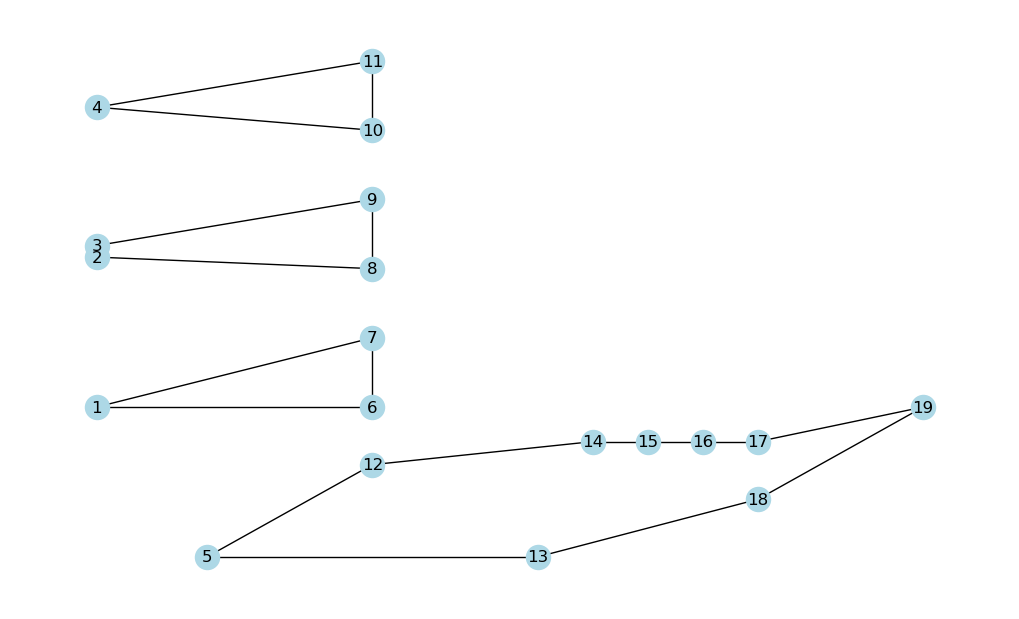

In [28]:
# get the solution to visualize
sol = model.getBestSol()

# Collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
edges = []
for (i,j) in x:
    if model.getSolVal(sol, x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
        edges.append( (i,j) )

# make figure look nicer
plt.figure(figsize=(10,6), dpi=100)

# create empty graph
optgraph = networkx.Graph()

# add edges
optgraph.add_edges_from(edges)

# draw the nodes, with labels in the position xy (see when we read the instance)
networkx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

# show drawing
plt.show()

In [29]:
edges = []
for (i,j) in x:
    if model.getSolVal(sol, x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
        edges.append( (i,j) )
G = networkx.Graph()
G.add_edges_from(edges)
components = list(networkx.connected_components(G))

print(components)

[{1, 6, 7}, {8, 9, 2, 3}, {10, 11, 4}, {5, 12, 13, 14, 15, 16, 17, 18, 19}]
